In [1]:
import main
import plot_inequality as plot_ineq
import importlib
import io_manager
import numpy as np

of_name = None
main_path = "C:/Users/Ben/My Drive/PhD/PhD Year 3/3rd Year Paper/Model/My Code/MH_Model/my_code/model_uncert/"
input_path = main_path + "input/50p_age_moms/"
trans_path_uncond = input_path + "MH_trans_uncond_age.csv"

trans_path_50p = input_path + "MH_trans_by_MH_clust_age.csv"
type_path_50p = input_path + "MH_clust_50p_age_pop_shares.csv"

do_dpi_calib = False
output_flag = False
myPars, myShocks, sols, sims = main.main_io(main_path, out_folder_name = of_name, 
                                            H_trans_uncond_path = trans_path_uncond, H_trans_path = trans_path_50p, H_type_pop_share_path = type_path_50p,
                                            output_flag = output_flag, do_dpi_calib = do_dpi_calib, do_eps_gg_calib=True)


*****Running main_io with default out_folder_name*****
Solver ran in 7.187210999982199 seconds
Calibrating with alpha_lab_targ = 0.33497447, w0_mean_targ = 2.1988928, w0_sd_targ = 0.29847395, 
                                        w1_targ = 0.2928040000000003, w2_targ = 0.2746706000000003, wH_targ = 0.051316846, phi_H_targ = 0.053118114,
                                        dpi_BB_targ = 0.50886095, dpi_GG_targ = 0.34358001, eps_gg_targ = 0.39124098057692314
***** Calibration iteration 0 *****
Calibrating epsilon_gg
my_eps_gg_mom: 0.39188756703943345
Calibrating w0_mu
Calibrating w0_sigma
***** Calibration iteration 1 *****
Calibrating w0_mu
Calibrating w0_sigma
***** Calibration iteration 2 *****
Calibrating w0_mu
Calibrating w0_sigma
Calibrating w1
Calibrating w2
***** Calibration iteration 3 *****
Calibrating w0_mu
Calibrating w0_sigma
Calibrating w1
Calibrating w2
***** Calibration iteration 4 *****
Calibrating w0_mu
Calibrating w0_sigma
Calibrating w1
Calibrating w2
***** Cal

In [2]:
from pars_shocks import Pars, Shocks
import pandas as pd
import model_uncert as model

def get_eps_gg_targ(myPars: Pars, target_folder_path)->float:
    file_path = target_folder_path + "mean_bad_MH_by_age.csv"
    bad_MH_age_data = pd.read_csv(file_path)
    # rename the columns
    bad_MH_age_data.columns = ['age', 'mean_badMH']
    bad_MH_age_data = bad_MH_age_data['mean_badMH'].to_numpy()
    return np.mean(bad_MH_age_data)

# print("target: ", get_eps_gg_targ(myPars, input_path))

def eps_gg_moment(myPars: Pars)->float:
    shocks = Shocks(myPars)
    H_hist = shocks.H_hist
    weighted_H_hist = model.gen_weighted_sim(myPars, H_hist) 
    good_MH_age_sim = np.sum(weighted_H_hist, tuple(range(H_hist.ndim - 1)))
    bad_MH_age_sim = 1 - good_MH_age_sim
    return np.mean(bad_MH_age_sim)

# print("moment: ", eps_gg_moment(myPars))

def eps_gg_mom_giv_eps(myPars: Pars, new_eps: float)->float:
    myPars.epsilon_gg = new_eps
    return eps_gg_moment(myPars)

# print("new moment: ", eps_gg_mom_giv_eps(myPars, 0.1))
# print(f"myPars.epsilon_gg = {myPars.epsilon_gg}")


# print(get_eps_gg_targ(myPars, input_path))
# print(eps_gg_mom_giv_eps(myPars, 0.05))
# print(f"myPars.epsilon_gg = {myPars.epsilon_gg}")





In [3]:
from typing import Tuple, Dict
import my_toolbox as tb
import solver
import simulate
def calib_eps_gg(myPars: Pars, main_path:str, tol:float, target:float, eps_gg_min:float, eps_gg_max:float)-> Tuple[float, float, Dict[str, np.array], Dict[str, np.array]]:
    eps_gg_moment = -999
    state_sols = {}
    sim_lc = {}

    # define the objective function
    get_eps_diff = lambda new_eps: eps_gg_mom_giv_eps(myPars, new_eps) - target
    calibrated_eps = tb.bisection_search(get_eps_diff, eps_gg_min, eps_gg_max, tol, myPars.max_iters, myPars.print_screen)
    myPars.epsilon_gg = calibrated_eps

    # solve, simulate model for the calibrated epsilon_gg
    eps_moment = eps_gg_mom_giv_eps(myPars, calibrated_eps)
    shocks = Shocks(myPars)
    state_sols = solver.solve_lc(myPars, main_path)
    sim_lc = simulate.sim_lc(myPars, shocks, state_sols)
    if myPars.print_screen > 0:
        print(f"calibrated epsilon_gg = {calibrated_eps}, epsilon_gg moment = {eps_moment}, target = {target}")

    return calibrated_eps, eps_moment, state_sols, sim_lc

# target = get_eps_gg_targ(myPars, input_path)
# calib_eps_gg(myPars, main_path, 1e-3, target, 0.01, 0.2)

   age  mean_badMH
0   25    0.482951
1   26    0.488518
2   27    0.478290
3   28    0.454662
4   29    0.460761


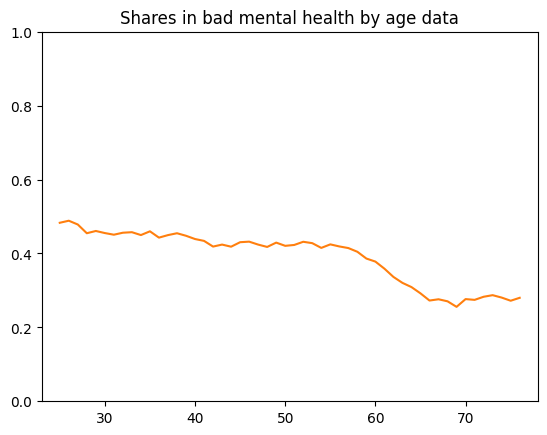

[0.48240711 0.45650464 0.48318578 0.44856766 0.47148683]


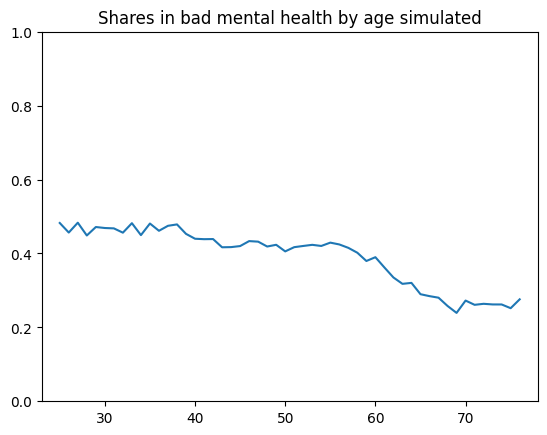

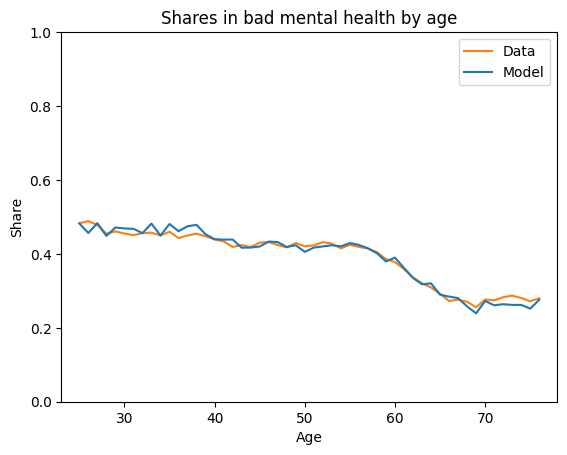

In [4]:

import model_uncert as model
import matplotlib.pyplot as plt
import pandas as pd
import my_toolbox as tb
import os
myShocks = Shocks(myPars)
H_hist = myShocks.H_hist

shares_y_lim = [0, 1.0]
# shares in bad health by earnings (maybe later by wage, hours, etc)
age_grid = myPars.age_grid
bad_MH_age_data = pd.read_csv(input_path + "mean_bad_MH_by_age.csv")
print(bad_MH_age_data.head())
# get second column as numpy array
bad_MH_age_data = bad_MH_age_data.to_numpy()
# plot shares in bad health by age
fig_bad_MH_data, ax_bad_MH_data = plt.subplots()
ax_bad_MH_data.plot(age_grid, bad_MH_age_data)
ax_bad_MH_data.set_title("Shares in bad mental health by age data")
ax_bad_MH_data.set_xlim([age_grid[0]-2, age_grid[-1]+2])    
ax_bad_MH_data.set_ylim(shares_y_lim)
plt.show()

# model shares in bad health by age
weighted_H_hist = model.gen_weighted_sim(myPars, H_hist) 
good_MH_age_sim = np.sum(weighted_H_hist, tuple(range(H_hist.ndim - 1)))
bad_MH_age_sim = 1 - good_MH_age_sim
print(bad_MH_age_sim[:5])
# print("good_MH_age_sim", good_MH_age_sim)
# print("bad_MH_age_sim", bad_MH_age_sim)
fig_bad_MH_sim, ax_bad_MH_sim = plt.subplots()
ax_bad_MH_sim.plot(age_grid, bad_MH_age_sim)
ax_bad_MH_sim.set_title("Shares in bad mental health by age simulated")
ax_bad_MH_sim.set_xlim([age_grid[0]-2, age_grid[-1]+2])
ax_bad_MH_sim.set_ylim(shares_y_lim)
plt.show()

label_lists = [["Data"], ["Model"]]
color_list = ["C1", "C0"]
corr_save_path = main_path + "output/H_trans_state_test/"
#if directory doesn't exist create it
if not os.path.exists(corr_save_path):
    os.makedirs(corr_save_path)
# save_path = corr_save_path + "shares_bad_MH.pdf"
save_path = None
fig_comb_bad_MH, ax_comb_bad_MH = tb.combine_plots([(fig_bad_MH_data, ax_bad_MH_data), (fig_bad_MH_sim, ax_bad_MH_sim)],
                                                    comb_fig_title = "Shares in bad mental health by age", x_label = "Age", y_label = "Share", 
                                                    label_lists = label_lists, colors= color_list, save_path = save_path)

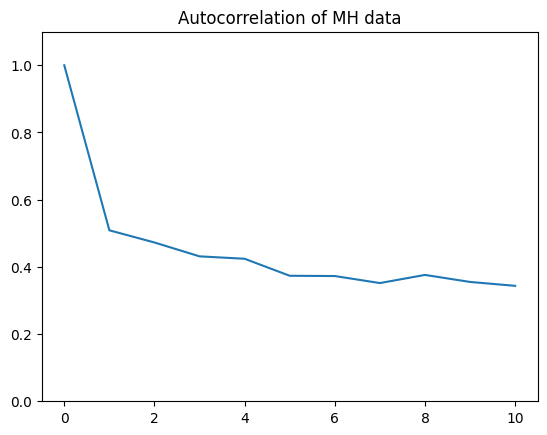

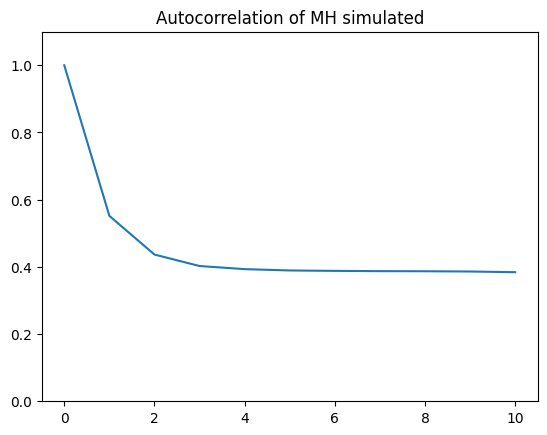

H_hist_ac [1.         0.55180079 0.43670479 0.40253075 0.39328559 0.38934417
 0.38809737 0.38728062 0.38701955 0.38622955 0.38417408]


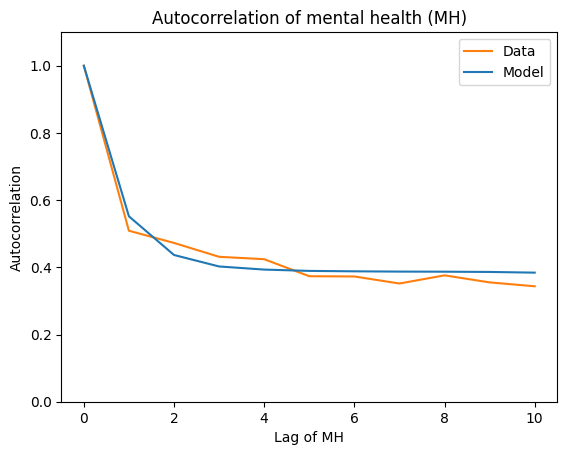

In [5]:

from typing import Tuple

def plot_autocorr(autocorr_data: np.array, var_name: str = None, y_lim: list = [0, 1.1], quietly: bool = False)-> Tuple[plt.Figure, plt.Axes]:
    fig_data, ax_data = plt.subplots()
    ax_data.plot(autocorr_data)
    ax_data.set_title(f"Autocorrelation of {var_name}")
    ax_data.set_ylim(y_lim)
    if not quietly:
        plt.show()
    return fig_data, ax_data


# Plot params
autocorr_y_lim = [0, 1.1]
# Data
autocorr_pd = pd.read_csv(input_path + "autocorr_matrix.csv")
MH_autocorr = autocorr_pd["MH"].values
fig_data_MH, ax_data_MH = plot_autocorr(MH_autocorr, "MH data", autocorr_y_lim, quietly = False)

# Model
H_hist = myShocks.H_hist[:, :, :, :-1]
H_hist_ac = tb.lagged_corr(H_hist, max_lag=10)
fig_sim_H_ac, ax_sim_H_ac = plot_autocorr(H_hist_ac, "MH simulated", autocorr_y_lim)
print("H_hist_ac", H_hist_ac)

# Combine
comb_fig_title_prefix = "Autocorrelation of "
label_lists = [["Data"], ["Model"]]
color_list = ["C1", "C0"]
x_label = "Lag"
y_label = "Autocorrelation"
# save_path =corr_save_path + "autocorr_MH.pdf"
save_path = None
fig_comb_MH_autocorr, ax_comb_MH_autocorr = tb.combine_plots([(fig_data_MH, ax_data_MH), (fig_sim_H_ac, ax_sim_H_ac)],
                                                                comb_fig_title = comb_fig_title_prefix + "mental health (MH)",  
                                                                x_label = x_label + " of MH", y_label = y_label,
                                                                label_lists = label_lists, colors= color_list, save_path = save_path)